<b> Stochastic logistic models reproduce experimental time series of microbial communities </b>

https://elifesciences.org/articles/55650v1

# Introduction


## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# For figures
import matplotlib.pyplot as plt
from matplotlib import gridspec


import time
np.random.seed(int(time.time()))

## Specific imports

In [2]:
#for figures
import matplotlib as mpl
from matplotlib import font_manager
font_manager._rebuild()

#maths
from scipy import stats

#our own definitions - the corresponding python files should be in the same folder as this notebook
from noise_analysis import noise_color
from noise_properties_plotting import noise_cmap_ww, noise_lim, PiecewiseNormalize, \
    PlotTimeseriesComparison, PlotNoiseColorComparison
from generate_timeseries import Timeseries
from noise_parameters import NOISE, MODEL


## Settings figures

In [3]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

# Figures


## Fig 1: analysis of experimental data

Load the experimental data.

In [17]:
# Load dataframes - the "Data" folder should be in the same folder as this notebook

# MartinPlatero plankton data

df_ts = {}

path = 'Data/MartinPlatero/'
files = ['41467_2017_2571_MOESM5_ESM_MartinPlatero_Plankton_Eukarya.csv']
    #['41467_2017_2571_MOESM4_ESM_MartinPlatero_Plankton_Bacteria.csv']
keys = ['plankton_eukarya']
    #['plankton_bacteria'] 

for i, f in enumerate(files):
    x = pd.read_csv(path+f, na_values='NAN', index_col=0)
    x = x.iloc[:, :-1] # delete last columns which contains details on the otu's
    
    # only keep 200 most abundant species
    sum_x = x.sum(axis='columns')
    
    x = x[sum_x >= np.sort(sum_x)[-200]]
    
    x = x.T # species are in rows instead of columns
    
    x.insert(0, 'time', [int(j[4:7]) for j in x.index]) # day
    
    x = x.groupby('time').agg('mean').reset_index()
    
    x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]
    
    df_ts[keys[i]] = x


# David stool data

files = ['Data/Faust/25_timeseries/25_timeseries.txt']
keys = ['David_stool_A']

for i, f in enumerate(files):
    x = pd.read_csv(f, na_values='NAN', delimiter='\t', header=None)
    
    x = x.T
    
    x.insert(0, 'time', range(len(x)))
    
    x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]
    
    df_ts[keys[i]] = x
    
# Caporaso body sites data

sites = ['F4_L_palm_L6', 'F4_tongue_L6']

for site in sites:
    file = 'Data/Caporaso/' + site + '.txt'
    key = 'Caporaso_' + site

    x = pd.read_csv(file, delimiter='\t', skiprows=1, index_col=0, header=None)
    #x = x[x.sum(axis='rows') > 0]

    x.index = ['time'] + ['species_%d' % j for j in range(1, len(x.index))]

    x = x.T

    # only keep 200 most abundant species
    if len(x.columns) > 201:
        sum_x = x.sum(axis='rows')

        sum_x['time'] = np.inf

        sum_x.sort_values(ascending=False, inplace=True)

        x = x[sum_x.index.tolist()[:201]]

    x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]

    df_ts[key] = x

In [21]:
df_ts['David_stool_A'].iloc[:,1]

0      1901.0000
1      1348.0000
2      1351.0000
3      1474.5000
4      1598.0000
         ...    
360     881.0000
361     469.0000
362     502.7639
363     692.4306
364    1038.0000
Name: species_1, Length: 365, dtype: float64

Calculate noise color of all time series

In [5]:
df_ns = {}

keys = ['plankton_eukarya', 'David_stool_A',
        'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

for i, key in enumerate(keys):
    ts = df_ts[key]
    df_ns[key] = noise_color(ts)['slope_linear']

Calculate width distribution

In [6]:
df_disdx = {}

#keys = ['Caporaso_F4_L_palm_L6'] 
keys =  ['plankton_eukarya', 'David_stool_A',
        'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

def fit_ratio(x):
    # ratios of succesive time points
    x = x = [x1/x2 for x1, x2 in zip(x[:-1], x[1:]) if x1 != 0 and x2 != 0 ] 
    
    if len(x) > 5:
        a, b, c = stats.lognorm.fit(x, floc=0)  # Gives the paramters of the fit
        stat, pval = stats.kstest(x, 'lognorm', args=((a, b, c))) # get pvalue for kolmogorov-smirnov test 
        # (null hypothesis: ratios of succesive time points follow lognorm distribution)

        return a, b, c, stat, pval
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

count = 0

for i, key in enumerate(keys):
    ts = df_ts[key]

    dx_ratio = pd.DataFrame(index=ts.columns, columns=['s', 'loc', 'scale', 'ks-stat', 'ks-pval'],dtype=float)
    dx_ratio.drop('time', inplace=True)

    for idx in dx_ratio.index:
        fit_par = fit_ratio(ts[idx].values)
        dx_ratio.loc[idx] = fit_par
        
        if False and fit_par[-1] > 0.5 and count < 10:
            print(key, idx, fit_par[-1])
            
            print(x[:5])

            x = ts[idx].values
            x_transf = x[:-1] / x[1:] # ratios of succesive time points
            x_transf = x_transf[np.isfinite(x_transf)] # remove infinities
            
            a, b, c, _, pval = fit_par
            
            x_fit = np.logspace(-1.5,1.5,100)
            pdf_fitted = stats.lognorm.pdf(x_fit,a,b,c) #Gives the PDF
            plt.figure()
            plt.hist(x_transf, alpha=0.4, normed=True, bins = np.logspace(-1.5,1.5,30))
            plt.plot(x_fit, pdf_fitted, label='%.2f, %.2f, %.2f'%(a,b,c))
            plt.xscale('log')
            plt.legend()
            plt.show()
            
            count += 1
    
    if count == 10:
        break;
        
    df_disdx[key] = dx_ratio


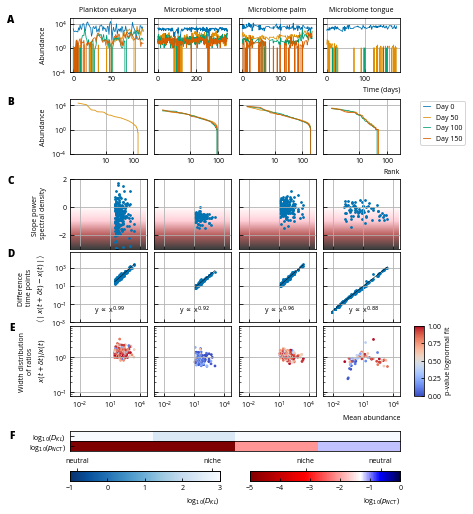

In [7]:
plotts = True # plot time series
plotra = True # plot rank abundance distribution
plotnc = True # plot noise color
plotdx = True # plot dx = x(t)-x(t-dt) as a function of mean x value
plotdisdx = True # plot 

keys = ['plankton_eukarya', 'David_stool_A',
        'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

titles = ['Plankton eukarya', 'Microbiome stool', 
          'Microbiome palm', 'Microbiome tongue']

fig = plt.figure(figsize=(0.9*ELIFE.FULLWIDTH,7))

lm = 0.15 # left margin
rm = 0.85 # right margin

gs_ts = gridspec.GridSpec(2, len(keys), top=0.97, bottom=0.7, left = lm, right=rm, hspace=0.5, wspace=0.1)
gs_ma = gridspec.GridSpec(3, len(keys), top=0.65, bottom=0.22, left = lm, right=rm, hspace=0.05, wspace=0.1)
gs_legend = gridspec.GridSpec(2, 1, top=0.97, bottom=0.7, left = 0.88, right=0.99, hspace=0.5, wspace=0.1)
gs_cbar = gridspec.GridSpec(3, 1, top=0.65, bottom = 0.22, left = 0.88, right=0.9, hspace=0.05, wspace=0.1)

gs1 = gridspec.GridSpec(2,1,hspace=0, left=lm, right= rm, top=0.15, bottom=0.11) # for neutrality
gs2 = gridspec.GridSpec(1,2,wspace=0.2, left=lm, right = rm, top = 0.07, bottom=0.05) # for colorbars neutrality

#axes = np.empty([5, len(keys)])

axes = [[0 for i in range(len(keys))] for j in range(5)]
for i in range(2):
    for j in range(len(keys)):
        if j == 0: # share axes except for timeseries
            axes[i][j] = fig.add_subplot(gs_ts[i,j])
            if i == 0:
                axes[i][j].set_title(titles[i])
        elif i == 0:
            axes[i][j] = fig.add_subplot(gs_ts[i,j], sharey=axes[i][0])
            axes[i][j].set_title(titles[j])
        else:
            axes[i][j] = fig.add_subplot(gs_ts[i,j], sharey=axes[i][0], sharex=axes[i][0])
        axes[i][j].grid()
        
for i in range(2,5):
    for j in range(len(keys)):
        if i-2 == 0 and j == 0: # share axes except for timeseries
            axes[i][j] = fig.add_subplot(gs_ma[i-2,j])
        elif i-2 == 0:
            axes[i][j] = fig.add_subplot(gs_ma[i-2,j], sharey=axes[i][0], sharex=axes[i][0])
        elif j == 0:
            axes[i][j] = fig.add_subplot(gs_ma[i-2,j], sharex=axes[i-1][j])
        else:
            axes[i][j] = fig.add_subplot(gs_ma[i-2,j], sharey=axes[i][0], sharex=axes[i-1][j])
        axes[i][j].grid()
axes = np.array(axes)

axes_cbar = fig.add_subplot(gs_cbar[-1])
axes_legend = fig.add_subplot(gs_legend[-1])
axes_legend.axis('off')

for i, key in enumerate(keys):
    ts = df_ts[key]
    mean = df_ts[key].mean()
    mean.drop('time', inplace=True)
    ts['time'] -= ts['time'].min()
    
    vmin = 1e-4
    vmax = 1e5

    # timeseries
    
    if plotts:
        ax = axes[0,i]

        sorted_species = mean.sort_values().index.tolist()[::-1]

        skip = max(1, int(len(ts) / 500))
        for species in sorted_species[::int((len(ts.columns)-1) / 4)]:
            ax.plot(ts['time'][::skip], ts[species][::skip])
        
        ax.set_yscale('log')
        
    # Rank abundance
    
    if plotra:
        ax = axes[1][i]

        selected_times = np.arange(ts['time'].min(), ts['time'].max(), 50)[:4]
        
        for t in selected_times:
            abundance_profile = ts[ts['time'] == t-1].values.flatten()[1:]
            ax.plot(range(1, len(abundance_profile) + 1), np.sort(abundance_profile)[::-1],
                       label='Day %d' % int(t))
        

        ax.set_xscale('log')
        ax.set_yscale('log')
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            axes_legend.legend(handles, labels, handlelength=1, fontsize=ELIFE.FONTSIZE)
        ax.set_ylim([vmin, vmax])
    
    # Noise color
    
    if plotnc:
        ax = axes[2][i]

        ax.set_xscale('log')

        ns = df_ns[key]
        sc = ax.scatter(mean, ns, vmin=0, vmax=10, s=3)

        xx = np.linspace(2, -3, 500).reshape([500, 1])
        ax.imshow(xx, cmap=noise_cmap_ww, vmin=noise_lim[0], vmax=noise_lim[1], extent=(vmin, vmax, -3, 2),
                     aspect='auto', alpha=0.75)
        ax.set_xlabel('Abundance')
        
        plt.setp(ax.get_xticklabels(), visible=False)
        
    # absolute timestep
    
    if plotdx:
        ax = axes[3][i]

        dx = (ts.values[1:, 1:] - ts.values[:-1, 1:])  # / x.values[:-1, 1:];
        dx[~np.isfinite(dx)] = np.nan
        mean_dx = np.nanmean(abs(dx), axis=0)

        p_lin = np.polyfit(np.log10(mean), np.log10(mean_dx), deg=1, cov=False)

        xx = [np.nanmin(mean.values), np.nanmax(mean.values)]
        ax.plot(xx, 10 ** (p_lin[1] + p_lin[0] * np.log10(xx)), c='k', linewidth=0.5)
        ax.annotate(r'y $\propto$ x$^{%.2f}$' % p_lin[0],(0.3,0.01))
        ax.scatter(mean, mean_dx, s=3)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xlabel('Mean abundance')
        plt.setp(ax.get_xticklabels(), visible=False)
        #ax.set_xticklabels(['']*10) # no ticklabels
    
    # distribution timestep
    
    if plotdisdx:
        ax = axes[4][i]
        
        dx_ratio = df_disdx[key]
        
        sc = ax.scatter(mean, dx_ratio['s'], c=dx_ratio['ks-pval'], vmin=0, vmax=1, cmap='coolwarm', s=3)

        # ax_disdx.legend()
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        if i == 0:
            fig.colorbar(sc, cax=axes_cbar)
            axes_cbar.set_ylabel('p-value lognormal fit')
        
    if i == 0:
        axes[0][i].set_ylabel('Abundance')
        axes[0][i].set_ylim([1e-4,1e5])
        axes[1][i].set_ylabel('Abundance')
        axes[1][i].set_ylim([1e-1,1e3])
        axes[1][i].set_xlim([5e-1,3e2])
        axes[2][i].set_ylabel('Slope power \n spectral density')
        axes[3][i].set_ylabel('Difference \n time points \n' + r'$\left< \mid x(t+\delta t) - x(t) \mid \right>$')
        # \langle \rangle
            #'Mean absolute \n difference between successive \n time points')
        axes[3][i].set_ylim([1e-3, 5e4])
        axes[4][i].set_ylabel('Width distribution \n of ratios \n' + r'$x(t + \delta t) / x(t)$')
        axes[4][i].set_xlim([1e-3, 5e4])
        axes[4][i].set_ylim([8e-2, 8e0])
    else:
        for j in range(5):
            plt.setp(axes[j][i].get_yticklabels(), visible=False)
    
    if i == len(keys) - 1:
        axes[0][i].set_xlabel('Time (days)', ha='right', x=1)
        axes[1][i].set_xlabel('Rank', ha='right', x=1)
        axes[1][i].set_xticks([10,100])
        axes[1][i].set_xticklabels([10,100])
        axes[4][i].set_xlabel('Mean abundance', ha='right', x=1)
        axes[4][i].set_xticks([1e-2, 1e1, 1e4])

for ax, label in zip(axes[:,0], ('A', 'B', 'C', 'D', 'E')):
    ax.text(-0.72, 1.05, label, transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')
    
# neutrality

neutrality =pd.read_csv('results/experimental/neutrality.csv', index_col=0)
neutrality = neutrality.loc[keys]

ax_KL = fig.add_subplot(gs1[0])
ax_clb_KL = fig.add_subplot(gs2[0])
ax_NCT = fig.add_subplot(gs1[1])
ax_clb_NCT = fig.add_subplot(gs2[1])
ax_KL.set_facecolor('lightgrey')
ax_NCT.set_facecolor('lightgrey')

ax_KL.text(-0.72*0.23, 1.05, 'F', transform=ax_KL.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')

x = np.log10(neutrality['KL'].values.astype(np.float64))
x = x.reshape([1, len(x)])
x[np.isinf(x)] = 3.0
mat_KL = ax_KL.matshow(x, origin='lower', 
                    cmap='Blues_r', aspect='auto', vmin=-1, vmax=3)
ax_KL.set_yticks([0])
ax_KL.set_yticklabels([r'log$_{10}$($D_{KL}$)'])

ax_KL.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=True, labelleft=True)

fig.colorbar(mat_KL, cax=ax_clb_KL, orientation='horizontal')
#ax_clb_KL.set_title(r'log$_{10}$($D_{KL}$)')
ax_clb_KL.set_xlabel(r'log$_{10}$($D_{KL}$)', ha='right', x=1)

x = np.log10(neutrality['NCT'].values.astype(np.float64))
x = x.reshape([1, len(x)])

vmin = -5; vmax = 0 # pvalue is max 1 = 1e0
norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
mat_NCT = ax_NCT.matshow(x, origin='lower', norm=norm, 
                     cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(mat_NCT, cax=ax_clb_NCT, orientation='horizontal')

ax_NCT.set_yticks([0])
ax_NCT.set_yticklabels([r'log$_{10}$($p_{NCT}$)'])

# Remove ticks
ax_NCT.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=True, labelleft=True)

ax_clb_NCT.set_xlabel(r'log$_{10}$($p_{NCT}$)', ha='right', x=1)
ax_clb2 = ax_clb_KL.twiny()
ax_clb_KL.xaxis.set_ticks_position('bottom')
#ax_clb2.xaxis.set_ticks_position('top')
ax_clb2.xaxis.set_ticks([0.05,0.95])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['neutral','niche'])
ax_clb2.tick_params(axis='x', direction='out')

ax_clb2 = ax_clb_NCT.twiny()
ax_clb_NCT.xaxis.set_ticks_position('bottom')
ax_clb2.xaxis.set_ticks_position('top')
#ax_clb2.xaxis.set_tick_params(direction='out', which='top')
ax_clb2.xaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                        1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['niche','neutral'])
ax_clb2.tick_params(axis='x', direction='out')
    
#fig.align_labels()
fig.align_ylabels(axes[:,0])

plt.show()

## Fig 2: Noise color

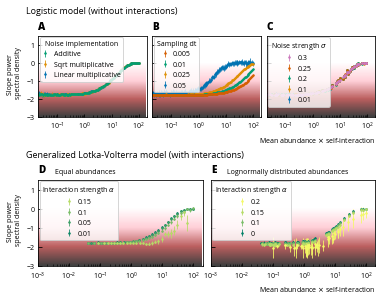

In [8]:
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 4))

ymin = -3
ymax = 1.5

# without interactions

yoff = 0.01

gs = gridspec.GridSpec(1, 3, top=0.88+yoff, bottom=0.6+yoff,
                       left=0.1, right=0.95, wspace=0.05, hspace=0.05)

gs_comb = gridspec.GridSpec(
    1, 1, top=0.95+yoff, bottom=0.55+yoff, left=0.07, right=0.95)

ax = fig.add_subplot(gs_comb[0], frameon=False)
ax.set_xlabel(r'Mean abundance $\times$ self-interaction', ha='right', x=1)
ax.set_ylabel('Slope power \n spectral density')
ax.set_xticks([])
ax.set_yticks([])

# ax.text(-0.02, 1.05, 'A', transform=ax.transAxes,
#      fontsize=10, fontweight='bold', va='top', ha='right')
ax.text(0, 1.08, 'Logistic model (without interactions)', transform=ax.transAxes,
        fontsize=9, va='top', ha='left')
# ax.text(0.5, 1.1, 'Logistic model (without interactions)', transform=ax.transAxes,
#        fontsize=9, va='top', ha='center')

# implementation

ax = fig.add_subplot(gs[0])
ax.text(0, 1.05, 'A', transform=ax.transAxes,
        fontsize=10, fontweight='bold', va='bottom', ha='left')

path = 'results/noise_color/no_interaction/'
files_noise = [path + 'noise_abundance_Langevin_linear.csv',
               path + 'noise_abundance_Langevin_sqrt.csv',
               path + 'noise_abundance_Langevin_constant.csv'][::-1]
# [path + 'noise_abundance_Ricker_linear.csv',
#[path + 'noise_abundance_Arato_linear.csv'][::-1]

# , 'Ricker linear', 'Arato linear'][::-1]
labels = ['Linear multiplicative', 'Sqrt multiplicative', 'Additive']

PlotNoiseColorComparison(
    files_noise, labels, legend_title='Noise implementation', ax=ax, masi=True)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([ymin, ymax])
ax.set_xlim([2e-2, 2e2])

# sampling dt

ax = fig.add_subplot(gs[1], sharex=ax, sharey=ax)
ax.text(0, 1.05, 'B', transform=ax.transAxes,
        fontsize=10, fontweight='bold', va='bottom', ha='left')

files_noise_samp = [
    path + 'noise_abundance_Langevin_samp%d.csv' % i for i in range(1, 5)]

labels = ['0.005', '0.01', '0.025', '0.05']  # , '0.25']

PlotNoiseColorComparison(
    files_noise_samp[::-1], labels[::-1], legend_title='Sampling dt', ax=ax, masi=True)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([ymin, ymax])
ax.tick_params(axis="both", left=True, labelleft=False)
ax.set_xlim([2e-2, 2e2])

# noise strength

ax = fig.add_subplot(gs[2], sharex=ax, sharey=ax)
ax.text(0, 1.05, 'C', transform=ax.transAxes,
        fontsize=10, fontweight='bold', va='bottom', ha='left')

files_noise_sigma = [
    path + 'noise_abundance_Langevin_linear_sigma%d.csv' % i for i in range(1, 6)]

labels = ['0.01', '0.1', '0.2', '0.25', '0.3']

PlotNoiseColorComparison(
    files_noise_sigma[::-1], labels, legend_title='Noise strength $\sigma$', ax=ax, masi=True)
ax.tick_params(axis="both", left=True, labelleft=False)
ax.set_xlabel('')
ax.set_ylabel('')

# with interactions

gs = gridspec.GridSpec(1, 2, top=0.38+yoff, bottom=0.08 +
                       yoff, left=0.1, right=0.95, wspace=0.05, hspace=0.05)

gs_comb = gridspec.GridSpec(
    1, 1, top=0.45+yoff, bottom=0.03+yoff, left=0.07, right=0.95)

ax = fig.add_subplot(gs_comb[0], frameon=False)
ax.set_xlabel(r'Mean abundance $\times$ self-interaction', ha='right', x=1)
ax.set_ylabel('Slope power \n spectral density')
ax.set_xticks([])
ax.set_yticks([])

# ax.text(-0.02, 1.05, 'B', transform=ax.transAxes,
#      fontsize=10, fontweight='bold', va='top', ha='right')
ax.text(0, 1.08, 'Generalized Lotka-Volterra model (with interactions)', transform=ax.transAxes,
        fontsize=9, va='top', ha='left')
# ax.text(0.5, 1.05, 'Generalized Lotka-Volterra model (with interactions)', transform=ax.transAxes,
#        fontsize=9, va='top', ha='center')

norm = mpl.colors.Normalize(vmin=0, vmax=0.21, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='summer')

ax = fig.add_subplot(gs[0])
ax.text(0, 1.05, 'D', transform=ax.transAxes,
        fontsize=10, fontweight='bold', va='bottom', ha='left')
ax.text(0.1, 1.05, 'Equal abundances', transform=ax.transAxes,
        fontsize=ELIFE.FONTSIZE, va='bottom', ha='left')
#ax.set_title('Equal abundances')

path = 'results/noise_color/with_interaction/'
files_noise_int = [
    path + 'noisecolor_Langevin_linear_interaction%d.csv' % i for i in [1, 2, 3, 6]]

labels = ['0.01', '0.05', '0.1', '0.15']

PlotNoiseColorComparison(files_noise_int, labels,
                         legend_title=r'Interaction strength $\alpha$', ax=ax, masi=True, interaction_colors=True)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([ymin, ymax])

ax = fig.add_subplot(gs[1], sharex=ax, sharey=ax)
ax.text(0, 1.05, 'E', transform=ax.transAxes,
        fontsize=10, fontweight='bold', va='bottom', ha='left')
ax.text(0.1, 1.05, 'Lognormally distributed abundances', transform=ax.transAxes,
        fontsize=ELIFE.FONTSIZE, va='bottom', ha='left')
#ax.set_title('Lognormally distributed abundances')

files_noise_pl = [path + 'noisecolor_Langevin_linear_powerlaw_sigma1.csv',
                  path + 'noisecolor_Langevin_linear_powerlaw_sigma2.csv',
                  path + 'noisecolor_Langevin_linear_powerlaw_sigma3.csv',
                  path + 'noisecolor_Langevin_linear_powerlaw_sigma4.csv']

labels = ['0', '0.1', '0.15', '0.2']

PlotNoiseColorComparison(files_noise_pl, labels,
                         legend_title=r'Interaction strength $\alpha$', ax=ax, masi=True, interaction_colors=True)
ax.tick_params(axis="both", left=True, labelleft=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([ymin, ymax])

plt.show()

## Fig 3 : Width ratios

In [9]:
path = 'results/width_ratios/'
df1 = pd.read_csv(path +  'width_lognormal_fit_1.csv')
df2 = pd.read_csv(path +  'width_lognormal_fit_1_interaction0.05.csv')
df3 = pd.read_csv(path +  'width_lognormal_fit_1_interaction0.1.csv')
df4 = pd.read_csv(path +  'width_lognormal_fit_1_interaction0.15.csv')

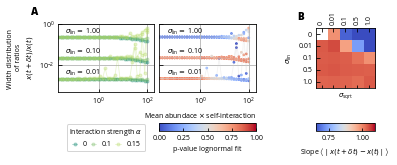

In [10]:
sigmas = [0.01, 0.1, 1.0]

cmap = mpl.cm.get_cmap('coolwarm') #viridis')

norm = mpl.colors.Normalize(vmin=0, vmax=0.21, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='summer')

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.3))

gs_l = gridspec.GridSpec(2,1, height_ratios=[8,1], hspace= 0.8, 
                         right=0.95, left=0.8, top=0.85, bottom=0.2)
gs_r = gridspec.GridSpec(2,2, height_ratios=[8,1], hspace= 0.8, wspace=0.05, 
                         right=0.65, left=0.15, top=0.85, bottom=0.2)

ax_mat = fig.add_subplot(gs_l[0])
ax = fig.add_subplot(gs_r[0])
ax2 = fig.add_subplot(gs_r[1], sharey=ax)

ax_mat.text(-0.2, 1.08, 'B', transform=ax_mat.transAxes,
      fontsize=10, fontweight='bold', va='bottom', ha='right')
ax.text(-0.2, 1.08, 'A', transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='bottom', ha='right')

ax_mat_cbar = fig.add_subplot(gs_l[1])
ax_legend = fig.add_subplot(gs_r[2])
ax_cbar = fig.add_subplot(gs_r[3])


df_slopes2 = pd.read_csv('results/slopes/slopes_equal_abundances.csv', index_col=0, na_values='NAN')
df_slopes2['slope'] = df_slopes2.iloc[:,2:12].mean(axis=1)
df_slopes2['slope_std'] = df_slopes2.iloc[:,2:12].std(axis=1)
df_slopes2.drop(['%d'%i for i in range(10)], axis=1, inplace=True)

slope = df_slopes2.drop(['implementation', 'interaction', 'slope_std'], axis=1)
std_slope = df_slopes2.drop(['implementation', 'interaction', 'slope'], axis=1)

slope = slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')
std_slope = std_slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')

slope = slope.unstack() #.iloc[:4, :4]

val = slope.values

mat = ax_mat.matshow(val, cmap='coolwarm', vmin=0.65, vmax=1.1)
ax_mat.set_xlabel(r'$\sigma_\mathregular{sqrt}$')
ax_mat.set_ylabel(r'$\sigma_\mathregular{lin}$')
ax_mat.set_xticks([0,1,2,3,4])
ax_mat.set_yticks([0,1,2,3,4])

ax_mat.set_xticklabels([0, 0.01, 0.1, 0.5, 1.0], rotation=90)
ax_mat.set_yticklabels([0, 0.01, 0.1, 0.5, 1.0])

cbar = plt.colorbar(mat, cax=ax_mat_cbar, orientation='horizontal')
cbar.set_label(r'Slope $\left< \mid x(t+\delta t) - x(t) \mid \right>$') #'Slope steps')

#for i, df, alpha in zip(range(4), [df1, df2, df3, df4], [0, 0.05, 0.1, 0.15]):
for i, df, alpha in zip(range(3), [df1, df3, df4], [0, 0.1, 0.15]):
    for j, sigma in enumerate(sigmas):
        w = df['sigma_%.2f_width_mean' % sigma]
        pval = df['sigma_%.2f_pval' % sigma]
        ss = df['ss']
        
        col = mapper.to_rgba(alpha)
        
        ax.plot(ss.values, w.values, c=col, alpha=0.3, marker='o', markersize=3, label=alpha if j==0 else "")
        ax2.plot(ss.values, w.values, c='lightgrey', alpha=0.3) #, label=alpha if j==0 else "")
        s_ax2 = ax2.scatter(ss.values, w.values,s=3, c = pval, cmap=cmap, vmin=0, vmax=1)
                        #c=col, label=alpha if j==0 else "")
        x = 2e-1 #ss.values[0]
        y = w.values[0]
        
        if i == 0:
            ax.annotate(r"$\sigma_\mathregular{lin} =$ %.2f" % sigma, xy=(x, y), xytext=(0.2*x, 1.5*y))
            ax2.annotate(r"$\sigma_\mathregular{lin} =$ %.2f" % sigma, xy=(x, y), xytext=(0.2*x, 1.5*y))

handles, labels = ax.get_legend_handles_labels()
ax_legend.legend(handles, labels, title='Interaction ' + r'strength $\alpha$', 
                 loc=9, ncol=3, columnspacing=0.5)
ax_legend.axis('off')

cbar = plt.colorbar(s_ax2, cax=ax_cbar, orientation='horizontal')
cbar.set_label('p-value lognormal fit')

ax.set_xscale('log')
#ax.set_xlabel(r'Mean abundace $\times$ self-interaction', ha='right', x=1)

ax.set_ylabel('Width distribution \n of ratios \n' + r'$x(t + \delta t) / x(t)$') #'Width distribution \n ratios of time points')
ax.set_xlim([2e-2,2e2])
ax2.set_ylim([5e-4,1e0])
ax.set_yscale('log')
ax.grid()

ax2.set_xscale('log')
ax2.tick_params(axis="both", left=True, labelleft=False)
ax2.set_xlabel(r'Mean abundace $\times$ self-interaction', ha='right', x=1)
#ax2.set_ylabel('Scale lognormal fit')
ax2.set_xlim([2e-2,2e2])

ax2.set_yscale('log')
ax2.grid()

plt.show()

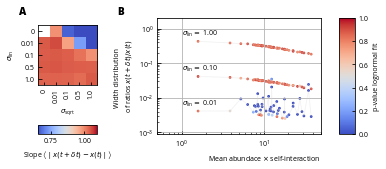

In [11]:
sigmas = [0.01, 0.1, 1.0]

cmap = mpl.cm.get_cmap('coolwarm') #viridis')

norm = mpl.colors.Normalize(vmin=0, vmax=0.21, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='summer')

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.3))

gs_l = gridspec.GridSpec(2,1, height_ratios=[8,1], hspace= 0.8, 
                         right=0.25, left=0.1, top=0.9, bottom=0.2)
gs_r = gridspec.GridSpec(2,2, height_ratios=[1,3], width_ratios=[10,1], hspace= 0.15, wspace=0.2, 
                         right=0.9, left=0.4, top=0.9, bottom=0.2)

ax_mat = fig.add_subplot(gs_l[0])

ax = fig.add_subplot(gs_r[:,0], sharey=ax)

ax_mat_tot = fig.add_subplot(gs_l[:])
ax_mat_tot.axis('off')

ax_mat_tot.text(-0.2, 1.1, 'A', transform=ax_mat_tot.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')
ax.text(-0.2, 1.1, 'B', transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')

ax_mat_cbar = fig.add_subplot(gs_l[1])
#ax_legend = fig.add_subplot(gs_r[0,1])
ax_cbar = fig.add_subplot(gs_r[:,1])

df_slopes2 = pd.read_csv('results/slopes/slopes_equal_abundances.csv', index_col=0, na_values='NAN')
df_slopes2['slope'] = df_slopes2.iloc[:,2:12].mean(axis=1)
df_slopes2['slope_std'] = df_slopes2.iloc[:,2:12].std(axis=1)
df_slopes2.drop(['%d'%i for i in range(10)], axis=1, inplace=True)

slope = df_slopes2.drop(['implementation', 'interaction', 'slope_std'], axis=1)
std_slope = df_slopes2.drop(['implementation', 'interaction', 'slope'], axis=1)

slope = slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')
std_slope = std_slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')

slope = slope.unstack() #.iloc[:4, :4]

val = slope.values

mat = ax_mat.matshow(val, cmap='coolwarm', vmin=0.65, vmax=1.1)
ax_mat.set_xlabel(r'$\sigma_\mathregular{sqrt}$')
ax_mat.set_ylabel(r'$\sigma_\mathregular{lin}$')
ax_mat.set_xticks([0,1,2,3,4])
ax_mat.set_yticks([0,1,2,3,4])

ax_mat.set_xticklabels([0, 0.01, 0.1, 0.5, 1.0], rotation=90)
ax_mat.set_yticklabels([0, 0.01, 0.1, 0.5, 1.0])

ax_mat.tick_params(axis='both', top=False, bottom=True, labelbottom=True, labeltop=False)

cbar = plt.colorbar(mat, cax=ax_mat_cbar, orientation='horizontal')
cbar.set_label(r'Slope $\left< \mid x(t+\delta t) - x(t) \mid \right>$') #'Slope steps')

df1 = pd.read_csv('results/width_ratios/width_lognormal_fit_experimental.csv')
df2 = pd.read_csv('results/width_ratios/width_lognormal_fit_experimental_interaction.csv')

#for i, df, alpha in zip(range(4), [df1, df2, df3, df4], [0, 0.05, 0.1, 0.15]):
for i, df, alpha, m in zip(range(1), [df1], [0], ['o']):
    #zip(range(3), [df1, df2], [0, 0.15], ['o', '^']):
    for j, sigma in enumerate(sigmas):
        w = df[['sigma_%.2f_width_mean_%d' % (sigma, d) for d in range(20)]].median(axis=1).values
        pval = df[['sigma_%.2f_pval_%d' % (sigma, d) for d in range(20)]].median(axis=1).values
        ss = df['ss'].values
        si = df['selfints'].values

        x = ss * si

        p = x.argsort()

        x = x[p]
        w = w[p]
        pval = pval[p]
        ss = ss[p]
        si = si[p]

        col = mapper.to_rgba(alpha)

        #ax.plot(x, w, c=col, alpha=0.3) #, label=alpha if j==0 else "")
        #ax.scatter(x, w, c=col, label=label if j==0 else "", s=3)
        ax.plot(x, w, c='lightgrey', alpha=0.3) #, label=alpha if j==0 else "")
        s_ax = ax.scatter(x, w, s=3, c = pval, cmap=cmap, vmin=0, vmax=1, marker=m)
                        #c=col, label=alpha if j==0 else "")
            
        x = 1e0 #ss.values[0]
        y = w[0]
        
        if i == 0:
            ax.annotate(r"$\sigma_\mathregular{lin} =$ %.2f" % sigma, xy=(x, y), xytext=(x, 1.5*y), ha='left')

#handles, labels = ax.get_legend_handles_labels()
#ax_legend.legend(handles, labels, #title='Interaction ' + r'strength $\alpha$', 
#                 loc=9, ncol=3, columnspacing=0.5)

#legend_elements = [Line2D([0], [0], marker='o', color='w', label='No interaction',
#                          markerfacecolor='grey', markersize=5),
#                   Line2D([0], [0], marker='^', color='w', label='With interaction',
#                          markerfacecolor='grey', markersize=5),]

#ax_legend.legend(handles=legend_elements, loc=2) #loc='center')
#ax_legend.axis('off')

cbar = plt.colorbar(s_ax, cax=ax_cbar, orientation='vertical') #orientation='horizontal')
cbar.set_label('p-value lognormal fit')

ax.set_xscale('log')
#ax.set_xlabel(r'Mean abundace $\times$ self-interaction', ha='right', x=1)

ax.set_ylabel('Width distribution \n of ratios ' + r'$x(t + \delta t) / x(t)$') #'Width distribution ratios \n of successive time points')
ax.set_xlim([5e-1,9e1])
ax.set_ylim([9e-4,2e0])
ax.set_yscale('log')

ax.set_xscale('log')
ax.set_xlabel(r'Mean abundace $\times$ self-interaction', ha='right', x=1)
ax.set_xlim([5e-1,5e1])

ax.set_yscale('log')
ax.grid()

plt.show()

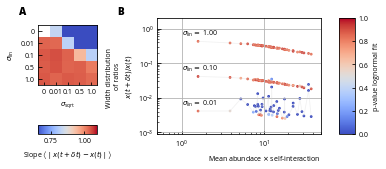

In [12]:
sigmas = [0.01, 0.1, 1.0]

cmap = mpl.cm.get_cmap('coolwarm') #viridis')

norm = mpl.colors.Normalize(vmin=0, vmax=0.21, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='summer')

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.3))

gs_l = gridspec.GridSpec(2,1, height_ratios=[8,1], hspace= 0.8, 
                         right=0.25, left=0.1, top=0.9, bottom=0.2)
gs_r = gridspec.GridSpec(2,2, height_ratios=[1,3], width_ratios=[10,1], hspace= 0.15, wspace=0.2, 
                         right=0.9, left=0.4, top=0.9, bottom=0.2)

ax_mat = fig.add_subplot(gs_l[0])

ax = fig.add_subplot(gs_r[:,0], sharey=ax)

ax_mat_tot = fig.add_subplot(gs_l[:])
ax_mat_tot.axis('off')

ax_mat_tot.text(-0.2, 1.1, 'A', transform=ax_mat_tot.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')
ax.text(-0.2, 1.1, 'B', transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')

ax_mat_cbar = fig.add_subplot(gs_l[1])
#ax_legend = fig.add_subplot(gs_r[0,1])
ax_cbar = fig.add_subplot(gs_r[:,1])

df_slopes = pd.read_csv('results/slopes/interaction_005.csv', index_col=0, na_values='NAN')
df_slopes2 = df_slopes[df_slopes.implementation == 'NOISE.LANGEVIN_LINEAR_SQRT']

Nts = 10

pd_opt_orig = pd.options.mode.chained_assignment
pd.options.mode.chained_assignment = None # avoid SettingWithCopyWarning
df_slopes2['slope'] = df_slopes2.loc[:,['ts_%d' % i for i in range(Nts)]].mean(axis=1)
df_slopes2.loc[:,'slope_std'] = df_slopes2.loc[:,['ts_%d' % i for i in range(Nts)]].std(axis=1)
df_slopes2.drop(['ts_%d'%i for i in range(Nts)], axis=1, inplace=True)
pd.options.mode.chained_assignment = pd_opt_orig # restore SettingWithCopyWarning

slope = df_slopes2.drop(['implementation', 'interaction', 'slope_std', 'noise_ct'], axis=1)
std_slope = df_slopes2.drop(['implementation', 'interaction', 'slope', 'noise_ct'], axis=1)

slope = slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')
std_slope = std_slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')

slope = slope.unstack() #.iloc[:4, :4]
std_slope = std_slope.unstack().iloc[:4, :4]

val = slope.values
val[0][0] = np.nan

mat = ax_mat.matshow(val, cmap='coolwarm', vmin=0.65, vmax=1.1)
ax_mat.set_xlabel(r'$\sigma_\mathregular{sqrt}$')
ax_mat.set_ylabel(r'$\sigma_\mathregular{lin}$')
ax_mat.set_xticks([0,1,2,3,4])
ax_mat.set_yticks([0,1,2,3,4])

ax_mat.set_xticklabels([0, 0.01, 0.1, 0.5, 1.0])
ax_mat.set_yticklabels([0, 0.01, 0.1, 0.5, 1.0])

ax_mat.tick_params(axis='both', top=False, bottom=True, labelbottom=True, labeltop=False)

cbar = plt.colorbar(mat, cax=ax_mat_cbar, orientation='horizontal')
cbar.set_label(r'Slope $\left< \mid x(t+\delta t) - x(t) \mid \right>$') #'Slope steps')

df1 = pd.read_csv('results/width_ratios/width_lognormal_fit_experimental.csv')
df2 = pd.read_csv('results/width_ratios/width_lognormal_fit_experimental_interaction.csv')

#for i, df, alpha in zip(range(4), [df1, df2, df3, df4], [0, 0.05, 0.1, 0.15]):
for i, df, alpha, m in zip(range(1), [df1], [0], ['o']):
    #zip(range(3), [df1, df2], [0, 0.15], ['o', '^']):
    for j, sigma in enumerate(sigmas):
        w = df[['sigma_%.2f_width_mean_%d' % (sigma, d) for d in range(20)]].median(axis=1).values
        pval = df[['sigma_%.2f_pval_%d' % (sigma, d) for d in range(20)]].median(axis=1).values
        ss = df['ss'].values
        si = df['selfints'].values

        x = ss * si

        p = x.argsort()

        x = x[p]
        w = w[p]
        pval = pval[p]
        ss = ss[p]
        si = si[p]

        col = mapper.to_rgba(alpha)

        #ax.plot(x, w, c=col, alpha=0.3) #, label=alpha if j==0 else "")
        #ax.scatter(x, w, c=col, label=label if j==0 else "", s=3)
        ax.plot(x, w, c='lightgrey', alpha=0.3) #, label=alpha if j==0 else "")
        s_ax = ax.scatter(x, w, s=3, c = pval, cmap=cmap, vmin=0, vmax=1, marker=m)
                        #c=col, label=alpha if j==0 else "")
            
        x = 1e0 #ss.values[0]
        y = w[0]
        
        if i == 0:
            ax.annotate(r"$\sigma_\mathregular{lin} =$ %.2f" % sigma, xy=(x, y), xytext=(x, 1.5*y), ha='left')

#handles, labels = ax.get_legend_handles_labels()
#ax_legend.legend(handles, labels, #title='Interaction ' + r'strength $\alpha$', 
#                 loc=9, ncol=3, columnspacing=0.5)

#legend_elements = [Line2D([0], [0], marker='o', color='w', label='No interaction',
#                          markerfacecolor='grey', markersize=5),
#                   Line2D([0], [0], marker='^', color='w', label='With interaction',
#                          markerfacecolor='grey', markersize=5),]

#ax_legend.legend(handles=legend_elements, loc=2) #loc='center')
#ax_legend.axis('off')

cbar = plt.colorbar(s_ax, cax=ax_cbar, orientation='vertical') #orientation='horizontal')
cbar.set_label('p-value lognormal fit')

ax.set_xscale('log')
#ax.set_xlabel(r'Mean abundace $\times$ self-interaction', ha='right', x=1)

ax.set_ylabel('Width distribution \n of ratios \n' + r'$x(t + \delta t) / x(t)$') #'Width distribution \n ratios of time points')
ax.set_xlim([5e-1,9e1])
ax.set_ylim([9e-4,2e0])
ax.set_yscale('log')

ax.set_xscale('log')
ax.set_xlabel(r'Mean abundace $\times$ self-interaction', ha='right', x=1)
ax.set_xlim([5e-1,5e1])

ax.set_yscale('log')
ax.grid()

plt.show()

## Fig 4 Logistic model reproducing noise characteristics

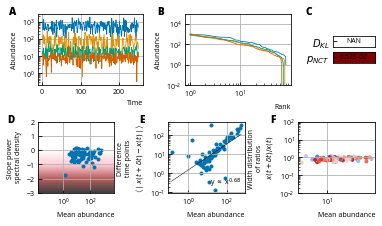

In [13]:
def mimic_experimental(interaction=0, connectivity=1, N=80):
    x = df_ts['David_stool_A'].values[150:, :]  # do not consider the traveling
    experimental_abundance = np.sort(x[0, :])[::-1]
    experimental_noise_color = noise_color(x.T)

    def find_ss_selfint(x):
        amplitude = 2.10E+00
        x0 = 2.87E+00
        k = 1.14E+00
        offset = -1.77E+00

        return 10**(-1/x0 * np.log(amplitude/(x-offset) - 1) + k)

    params = {}

    steadystate = (experimental_abundance[:N]).reshape([N, 1])

    selfints = - \
        find_ss_selfint(
            experimental_noise_color['slope_linear'].values[:N]) / steadystate.flatten()

    # interaction
    if interaction == 0:
        omega = np.zeros([N, N])
    else:
        omega = np.random.normal(0, interaction, [N, N])
        omega *= np.random.choice([0, 1], [N, N],
                                  p=[1-connectivity, connectivity])
    np.fill_diagonal(omega, selfints)

    params['interaction_matrix'] = omega

    # no immigration
    params['immigration_rate'] = np.zeros([N, 1])

    # different growthrates determined by the steady state
    params['growth_rate'] = - (omega).dot(steadystate)

    params['initial_condition'] = np.copy(
        steadystate) * np.random.normal(1, 0.1, steadystate.shape)

    params['noise'] = 2.5

    params['noise_linear'] = 2.5
    params['noise_sqrt'] = 0  # 0.005*steadystate #*np.sqrt(steadystate)
    
    np.save('test-params2.npy', params)
    
    ts = Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR_SQRT,
                    dt=0.01, tskip=19, T=50.0, seed=int(time.time())).timeseries
    ts.time = np.arange(1, len(ts)+1)

    return ts


def figure_characteristics_timeseries(ts):
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 3))

    gs1 = gridspec.GridSpec(1, 3, width_ratios=[
                            2.5, 2.5, 1], wspace=0.5, hspace=0.3, left=0.1, right=0.95, top=0.95, bottom=0.62)
    gs2 = gridspec.GridSpec(1, 3, wspace=0.7, hspace=0.4,
                            left=0.1, right=0.95, top=0.45, bottom=0.12)

    # timeseries
    ax = fig.add_subplot(gs1[0])
    ax.text(-0.2, 1.1, 'A', transform=ax.transAxes, fontsize=10,
            fontweight='bold', va='top', ha='right')
    ax.grid()

    PlotTimeseriesComparison([ts], composition=['ts'], vertical=False, fig=ax)

    ax = fig.add_subplot(gs1[1])
    ax.text(-0.2, 1.1, 'B', transform=ax.transAxes, fontsize=10,
            fontweight='bold', va='top', ha='right')
    ax.grid()
    # , ffig = 'figures/interaction_rescaled_model.png')
    PlotTimeseriesComparison([ts], composition=['ra'], fig=ax)
    ax.set_ylim([1e-2, 1e5])

    ax = fig.add_subplot(gs1[-1], frameon=False)
    ax.tick_params(left=False, labelleft=False,
                   bottom=False, labelbottom=False)
    ax.text(-0.5, 1.1, 'C', transform=ax.transAxes, fontsize=10,
            fontweight='bold', va='top', ha='right')

    sub_gs = gs1[0, -1].subgridspec(4, 1,
                                    height_ratios=[1.5, 1, 1, 1.5], hspace=0.3)
    ax_KL = fig.add_subplot(sub_gs[1])
    ax_NCT = fig.add_subplot(sub_gs[2])
    # , ffig = 'figures/interaction_rescaled_model.png')
    PlotTimeseriesComparison([ts], composition=['nn'], fig=[ax_KL, ax_NCT])

    # characteristics

    for i, (char, letter) in enumerate(zip(['nc', 'dx', 'disdx'], ['D', 'E', 'F'])):
        ax = fig.add_subplot(gs2[i])
        ax.text(-0.3, 1.1, letter, transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='top', ha='right')

        ax.grid()
        # , ffig = 'figures/interaction_rescaled_model.png')
        PlotTimeseriesComparison([ts], composition=[char], fig=ax)
        if char == 'disdx':
            ax.set_ylim([1e-2, 1e2])
            ax.set_ylabel('Width distribution \n of ratios \n' +
                          r'$x(t + \delta t) / x(t)$')
        elif char == 'dx':
            ax.set_ylabel('Difference \n time points \n' +
                          r'$\left< \mid x(t+\delta t) - x(t) \mid \right>$')

    # fig.align_labels()

#KL = np.zeros(100)
#NCT = np.zeros(100)

if True:
    ts = mimic_experimental(interaction=0)
    figure_characteristics_timeseries(ts)
    plt.show()

In [14]:
def check_neutrality_100_timeseries():
    for i in range(100):
        print(i)
        ts = mimic_experimental()
        KL[i] = KullbackLeibler_neutrality(ts)
        norm_ts = ts.values[:, 1:].copy()
        norm_ts /= norm_ts.sum(axis=1, keepdims=True)
        NCT[i] = neutral_covariance_test(norm_ts, ntests=500, method='Kolmogorov', seed=56)

    print("KL", KL)
    print("NCT", NCT)

# check_neutrality_100_timeseries()

## Reproduce noise characteristics in presence of noise

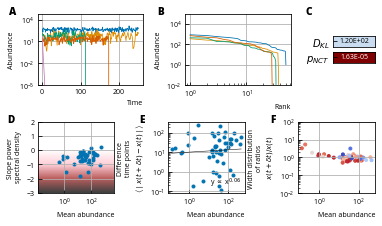

In [15]:
ts = mimic_experimental(interaction=0.02, connectivity=0.1, N=50)
figure_characteristics_timeseries(ts)
plt.show()